In [1]:
using AutoRisk
using Distributions
using PGFPlots

In [2]:
type BudgetTimer
    budget::Float64 # budget in seconds
    start_time::Float64
    pause_start::Float64
    function BudgetTimer(budget::Float64)
        new(budget, time())
    end
end

function has_time_remaining(timer::BudgetTimer)
    return (time() - timer.start_time) < timer.budget
end

function pause(timer::BudgetTimer)
    timer.pause_start = time()
end

function unpause(timer::BudgetTimer)
    timer.start_time += time() - timer.pause_start
end

function past_fraction(timer::BudgetTimer, fraction::Float64)
    return (time() - timer.start_time) / timer.budget > fraction
end

past_fraction (generic function with 1 method)

In [3]:
function normalize_log_probs(w::Array{Float64}, axis::Int = 1)
    exp_values = exp(w .- maximum(w, axis))
    probs = exp_values ./ sum(exp_values, axis)
    return probs
end

function get_gmm_dists(mus::Array{Float64}, sigmas::Array{Float64})
    K = size(mus, 2)
    try
        dists = [MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:K]
    catch e
        println("exception raised while getting the gmm dists: $(e)")
        for i in 1:K
            println("component $(i)")
            println("mus: $(mus[:,i])")
            println("sigmas: $(sigmas[:,:,i])")
        end
        throw(e)
    end
end

function compute_gmm_ll(samples::Array{Float64}, pis::Array{Float64}, mus::Array{Float64}, 
    sigmas::Array{Float64}, samp_w::Array{Float64} = ones(size(samples, 2)))
    N, K = size(samples, 2), length(pis)
    dists = get_gmm_dists(mus, sigmas)
    ll = 0
    for sidx in 1:N
        total = 0
        for k in 1:K
            total += pis[k] * pdf(dists[k], samples[:, sidx])
        end
        ll += samp_w[sidx] * log(total)
    end
    return ll
end

function fit_gmm(samples::Array{Float64}; samp_w::Array{Float64} = ones(1, size(samples,2)), 
        max_iters::Int = 30, tol::Float64 = 1e-2, num_components::Int = 2)
    # init
    N, K, D = size(samples, 2), num_components, length(samples[:, 1])
    w = zeros(K, N)
    
    mus = zeros(D, K)
    step = Int(ceil(D / K))
    for k in 1:K
        s = (k-1) * step
        e = s + step
        mus[:,k] = mean(samples[:, s+1:e],2)
    end
    
    sigmas = zeros(D, D, K)
    for k in 1:K
        sigmas[:,:,k] = eye(D)
    end
    pis = rand(K)
    pis ./= sum(pis)
    dists = get_gmm_dists(mus, sigmas)
    prev_ll = compute_gmm_ll(samples, pis, mus, sigmas)
    for iteration in 1:max_iters
        # e-step
        log_pis = log(pis)
        for sidx in 1:N
            for k in 1:K
                w[k, sidx] = log_pis[k] + logpdf(dists[k], samples[:, sidx])
            end
        end
        w = normalize_log_probs(w)
        w .*= samp_w # account for sample probability

        # m-step
        pis = sum(w, 2) ./ sum(w)
        
        mus = zeros(D, K)
        for k in 1:K
            for sidx in 1:N
                mus[:, k] += w[k,sidx] * samples[:,sidx]
            end
            mus[:, k] ./= sum(w[k,:])
        end
        
        if any(isnan(mus))
            pretty_print(w)
            readline()
        end
        
        sigmas = ones(D,D,K) * 1e-8
        for k in 1:K
            for sidx in 1:N
                diff = samples[:,sidx] - mus[:, k]
                sigmas[:, :, k] += w[k, sidx] * (diff * transpose(diff))
            end
            sigmas[:, :, k] ./= sum(w[k, :])
        end
        
        # check for convergence
        ll = compute_gmm_ll(samples, pis, mus, sigmas, samp_w)
#         println("iter $(iteration) ll $(ll)")
        if abs(ll - prev_ll) < tol
            break
        else
            prev_ll = ll
            dists = get_gmm_dists(mus, sigmas)
        end
    end
    return pis, mus, sigmas
end

fit_gmm (generic function with 1 method)

pis: [0.344502; 0.336074; 0.319424]
mus: [1.96133 -1.92873 -2.01418; 1.95937 1.93252 -2.11081]
sigmas: [1.06933 0.995691; 0.995691 1.12279]

[0.939678 -0.826998; -0.826998 0.91538]

[0.996971 -0.00807201; -0.00807201 1.00737]
pis: [0.518731; 0.481269]
mus: [1.49598 -1.47942]
sigmas: [0.337718]

[0.334197]


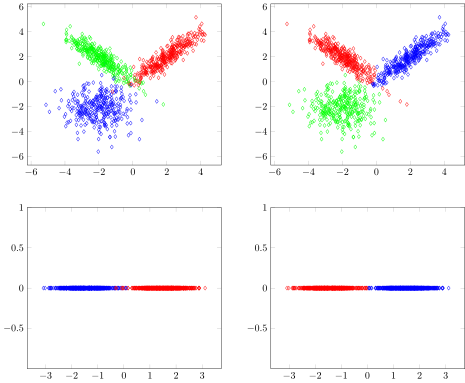

In [4]:
# check the EM implementation
g = GroupPlot(2, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
sc = "{a={mark=diamond,blue},b={mark=diamond,red},c={mark=diamond,green}}"

# 2d check
num_samples = 1000
samples = zeros(2, num_samples)
gauss1 = MvNormal([-2.,-2.],[[1., 0.] [0., 1.]])
gauss2 = MvNormal([2.,2.],[[1., .9] [.9, 1.]])
gauss3 = MvNormal([-2.,2.],[[1., -.9] [-.9, 1.]])
z = String[]
for i in 1:size(samples, 2)
    v = rand()
    if v < .33
        samples[:, i] = rand(gauss1)
        push!(z, "a")
    elseif v < .66
        samples[:, i] = rand(gauss2)
        push!(z, "b")
    else
        samples[:, i] = rand(gauss3)
        push!(z, "c")
    end
end
scatter_orig = Plots.Scatter(samples[1,:], samples[2,:], z, scatterClasses=sc)
push!(g, scatter_orig)

pis, mus, sigmas = fit_gmm(samples, num_components = 3)
println("pis: $(pis)")
println("mus: $(mus)")
println("sigmas: $(sigmas)")

N, K = size(samples, 2), length(pis)
dists = [MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:K]
z = String[]
for sidx in 1:N
    p1 = pis[1] * pdf(dists[1], samples[:, sidx])
    p2 = pis[2] * pdf(dists[2], samples[:, sidx])
    p3 = pis[3] * pdf(dists[3], samples[:, sidx])
    
    if p1 > p2 && p1 > p3
        cur_z = "a"
    elseif p2 > p1 && p2 > p3
        cur_z = "b"
    else
        cur_z = "c"
    end
    push!(z, cur_z)
end
scatter_pred = Plots.Scatter(samples[1,:], samples[2,:], z, scatterClasses=sc)
push!(g, scatter_pred)

# 1d check
samples = zeros(1, num_samples)
gauss1 = Normal(-1.5, .6)
gauss2 = Normal(1.5, .6)
z = String[]
samp_w = Float64[]
for i in 1:size(samples, 2)
    if rand() > .5
        samples[:, i] = rand(gauss1)
        push!(z, "a")
        push!(samp_w, 1.)
    else
        samples[:, i] = rand(gauss2)
        push!(z, "b")
        push!(samp_w, 1.)
    end
end
scatter_orig = Plots.Scatter(samples[1,:], zeros(length(samples[1,:])), z, scatterClasses=sc)
push!(g, scatter_orig)

pis, mus, sigmas = fit_gmm(samples, samp_w = reshape(samp_w, 1, length(samp_w)))
println("pis: $(pis)")
println("mus: $(mus)")
println("sigmas: $(sigmas)")

N, K = size(samples, 2), length(pis)
dists = [MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:K]
z = String[]
for sidx in 1:N
    p1 = pis[1] * pdf(dists[1], samples[:, sidx])
    p2 = pis[2] * pdf(dists[2], samples[:, sidx])
    cur_z = p1 > p2 ? "a" : "b"
    push!(z, cur_z)
end
scatter_pred = Plots.Scatter(samples[1,:], zeros(length(samples[1,:])), z, scatterClasses=sc)
push!(g, scatter_pred)

g

In [5]:
# Agent
abstract Agent
@with_kw type GaussianOneDAgent <: Agent
    μ::Float64 = 0.
    σ::Float64 = 1.
end
step(agent::GaussianOneDAgent, state::Array{Float64}) = [randn() * agent.σ + agent.μ]

# Sampler
abstract Sampler

function Distributions.pdf(sampler::Sampler, x::Array{Float64})
    if length(size(x)) > 1
        D, N = size(x)
        w = ones(N)
        for i in 1:N
            w[i] = prod(pdf(sampler.dists[j], x[j, i]) for j in 1:D)
        end
            return w
    else
        return prod(pdf(sampler.dists[i], x[i]) for i in 1:length(x))
    end
end

        function sample!(sampler::Sampler, x::Array{Float64}; xmin::Float64=0., xmax::Float64=0.)
    for (i, dist) in enumerate(sampler.dists)
        x[i] = rand(dist) 
    end
end
# base update does nothing
update!(sampler::Sampler, feedback::Float64) = sampler
update!(sampler::Sampler, feedback::Float64, true_sampler::Sampler) = sampler
reset_dists!(sampler::Sampler, dists::Any) = sampler

# basic sampler
type BasicSampler <: Sampler
    dists::Vector{Distribution}
end

type CEMSampler <: Sampler
    dists::Any
    update_dists_every::Int
    samples::Array{Float64}
    stats::Array{Float64}
    cur_idx::Int
    keep_ratio::Float64
    num_components::Int
    function CEMSampler(dists::Any; update_dists_every::Int = 100, keep_ratio::Float64 = .5, num_components::Int = 3)
        return new(dists, update_dists_every, zeros(length(dists), update_dists_every), 
        zeros(update_dists_every), 0, keep_ratio, num_components)
    end
end
        
function softmax(values::Array{Float64})
    exp_values = exp(values .- maximum(values))
    probs = exp_values ./ sum(exp_values)
    return probs
end

# update stats associated with the most recent sample
function update_dists!(sampler::CEMSampler, true_w::Array{Float64}, selection_method::String = "prop")
    if selection_method == "top"
        sorted_idxs = sortperm(abs(sampler.stats))
        start_keep_idx = length(sorted_idxs) - Int(ceil(length(sorted_idxs) * sampler.keep_ratio))
        samples = sampler.samples[:, sorted_idxs[start_keep_idx:end]]
        true_w = true_w[sorted_idxs[start_keep_idx:end]]
    else
        utility_weights = softmax(abs(sampler.stats))
        true_w = true_w .* utility_weights
        samples = sampler.samples
    end
    for (i, dist) in enumerate(sampler.dists)
        proposal_w = pdf(dist, reshape(samples[i,:], 1, length(samples[i,:])))
        samp_w = true_w ./ proposal_w
        samp_w = reshape(samp_w, 1, length(samp_w))
        pis, mus, sigmas = fit_gmm(samples, samp_w = samp_w, num_components = sampler.num_components)
                
        normals = MvNormal[MvNormal(mus[:,k], sigmas[:,:,k]) for k in 1:length(pis)]
        sampler.dists[i] = MixtureModel(normals, reshape(pis, length(pis)))
    end
end

function update!(sampler::CEMSampler, feedback::Float64, true_sampler::Sampler)
    sampler.stats[sampler.cur_idx] = feedback
    if sampler.cur_idx == sampler.update_dists_every
        true_w = pdf(true_sampler, sampler.samples)
        update_dists!(sampler, true_w)
        sampler.cur_idx = 0
    end
end
function sample!(sampler::CEMSampler, x::Array{Float64}; xmin::Float64=-1., xmax::Float64=1.)
    sampler.cur_idx += 1
    for (i, dist) in enumerate(sampler.dists)
        x[i] = rand(dist)[1]
        x[i] = min(max(env.x[i], env.xmin), xmax)
    end
    sampler.samples[:, sampler.cur_idx] = x
    return x
end

function reset_dists!(sampler::CEMSampler, dists::Any)
    sampler.dists = copy(dists)
    sampler.cur_idx = 0
end

# env
abstract Env
@with_kw type OneDEnv <: Env
    xmin::Float64 = -10.
    xmax::Float64 = 10
    x::Array{Float64} = [0.]
    true_sampler::Sampler = BasicSampler([Uniform(xmin, xmax)])
    sampler::Sampler = BasicSampler([Uniform(xmin, xmax)])
end
function reset(env::OneDEnv) 
            sample!(env.sampler, env.x, xmin=env.xmin, xmax=env.xmax)
    env.x
end
function reset(env::OneDEnv, x::Array{Float64})
    env.x = x
end
function update!(env::OneDEnv, feedback::Float64)
    update!(env.sampler, feedback, env.true_sampler)
end
function step(env::OneDEnv, a::Array{Float64})
    env.x += a[1]
    if env.x[1] > env.xmax
        r = 1.
        done = true
    elseif env.x[1] < env.xmin
        r = 0.
        done = true
    else
        r = 0.
        done = false
    end
    return (env.x, r, done)
end

step (generic function with 2 methods)